## An analysis of Reddit comments about HBO’s Euphoria to understand viewers’ experiences and reactions
### Analysis based on posts and comments on the `r/euphoria` subreddit  

#### 3.a Topic Modeling with `BERTopic`

*input*: corpus, embedding model  
*output*: topics, visualization

*tools*:  
`BERTopic`

*about*:  
`BERTopic` is a topic modeling technique that leverages BERT embeddings and a class-based TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.


In [1]:
# %pip install bertopic
# %pip install bertopic[visualization]
# no matches found for bertopic visualization

In [2]:
import pandas as pd
import numpy as np
# going to try modeling with raw comments and cleaned comments
# data_raw = pd.read_pickle('../dat/s2_rue_comments.pkl')
# data_raw = list(data_raw[0])
data_clean = pd.read_pickle('../dat/corpus_s1.pkl')
# data_clean = list(data_clean[0])

In [3]:
from bertopic import BERTopic

Modeling with raw data wasn't ideal. Spam ended up becoming topics.  

---
**Modeling with clean data**

In [4]:
# need to set environment variable to disable token parallelization
# see issue https://github.com/huggingface/transformers/issues/5486
TOKENIZERS_PARALLELISM = False

In [5]:
data_clean2 = data_clean.dropna()

In [6]:
# model = BERTopic(calculate_probabilities=True, nr_topics=20)
# topics, probabilities= model.fit_transform(list(data_clean2[0]))

---

**USING K-MEANS TO DETERMINE CLUSTERS**

In [7]:
import spacy
nlp = spacy.load('en_core_web_sm')
sw_spacy = nlp.Defaults.stop_words | {'rt', 'via', '…'}
add_stopwords = ['i', 'just','did', 'ab', 'amp', 'ml', 'xb','abc', 'abcb', 'abcny', 'abd', 'abdabca', 'fs', 
                  'zpqxhxhzanapjsjbf', 'zqcsrpwsge', 'zqnuhckwdqwrhkuo', 'zs', 'zshwbhethehenozxfyqg',
                  'zsmkbrmwngzsibrntkt', 'zy', 'zwhnrmujykdxmntiub', 'afqjcnguytghbsuvixmglpwzqbg', 'ebecadcbdfcbafbdb',
                  'abfbmltmqspf', 'abfafebfbad', 'episode', 'season', 's', 'lol']
 
# using spacy stopwords instead of sklearn
stop_words = sw_spacy.union(add_stopwords)

In [8]:
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(ngram_range=(1, 2),stop_words=stop_words)
from sklearn.cluster import KMeans

cluster_model = KMeans(n_clusters=10)
model = BERTopic(hdbscan_model=cluster_model,verbose=True,diversity=1,top_n_words=10, 
                       embedding_model="all-mpnet-base-v2", nr_topics=10,
                       vectorizer_model=vectorizer_model,calculate_probabilities=True)
topics, probabilities = model.fit_transform(list(data_clean2[0]))

Batches: 100%|██████████| 115/115 [02:57<00:00,  1.54s/it]
2022-08-11 10:11:06,248 - BERTopic - Transformed documents to Embeddings
2022-08-11 10:11:31,494 - BERTopic - Reduced dimensionality
2022-08-11 10:11:31,692 - BERTopic - Clustered reduced embeddings
2022-08-11 10:11:35,446 - BERTopic - Reduced number of topics from 10 to 10


In [9]:
model.get_topic_freq().head()

,Topic,Count
0,1,575
1,4,556
2,2,493
3,5,394
4,9,370


In [10]:
model.get_topic(0)

[('addict', 0.02861022046742609),
 ('think', 0.018769290911854097),
 ('people', 0.018065479470360704),
 ('like', 0.018044284315288338),
 ('rue', 0.014686075319035962),
 ('year', 0.010383413671874321),
 ('way', 0.009426267624836535),
 ('want', 0.00912540305808374),
 ('diagnose', 0.009019079096174096),
 ('friend', 0.008679071285022934)]

In [11]:
# save model
model.save("../models/bertopic_s1")

In [12]:
# load model
# model_clean = BERTopic.load('../models/bertopic_s1')

**Visualization**

In [13]:
model.visualize_topics()

In [14]:
model.visualize_heatmap(top_n_topics=10)

In [15]:
from umap import UMAP

sentence_model = SentenceTransformer("all-mpnet-base-v2")
embeddings = sentence_model.encode(list(data_clean2[0]), show_progress_bar=True)

reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
model.visualize_documents(list(data_clean2[0]), reduced_embeddings=reduced_embeddings)

Batches: 100%|██████████| 115/115 [04:14<00:00,  2.22s/it]


In [16]:
# save plotly visualization as html file
s1_doc_plot = model.visualize_documents(list(data_clean2[0]), reduced_embeddings=reduced_embeddings)  
s1_doc_plot.write_html("../plots/s1_doc_plot.html")

In [ ]:
# # save as image just in case
# # import kaleido
# %pip install kaleido
# s1_doc_plot.write_image("../plots/s1_doc_plot.png")

**Topic Reduction**

this model a few topics that are overlapping

In [21]:
# topic reduction after training
new_topics, new_probs = model.reduce_topics(list(data_clean2[0]), topics, probabilities, nr_topics=8)

2022-08-11 10:29:03,658 - BERTopic - Reduced number of topics from 10 to 8


In [22]:
model.get_topic_info()

,Topic,Count,Name
0,0,789,0_rue_character_like_know
1,1,556,1_scene_like_rue_music
2,2,555,2_jule_love_friend_way
3,3,493,3_agree_like_thing_read
4,4,370,4_jule_like_know_cal
5,5,362,5_addict_think_like_people
6,6,308,6_like_think_friend_people
7,7,222,7_rue_like_think_year


In [23]:
model.visualize_barchart(top_n_topics=8)

---

#### Sentiment analysis of topics

In [27]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [35]:
def sentiment_scores(sentence):
# Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
# polarity_scores method of SentimentIntensityAnalyzer
# oject gives a sentiment dictionary.
# which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
    # print("Overall sentiment dictionary is : ", sentiment_dict)
    # print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative")
    # print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral")
    # print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive")
    # print("Sentence Overall Rated As", end = " ")
    # decide sentiment as positive, negative and neutral
    # if sentiment_dict['compound'] >= 0.05 :
    #     x = "Positive"
    # elif sentiment_dict['compound'] <= - 0.05 :
    #     x = "Negative"
    # else :
    #     x = "Neutral"
    return sentiment_dict['compound']


In [30]:
# group data by topic and apply sentiment analysis
data_clean2['topic'] = topics

In [36]:
# group comments by topic
data_clean2['senti'] = data_clean2[0].apply(sentiment_scores)

<AxesSubplot:>

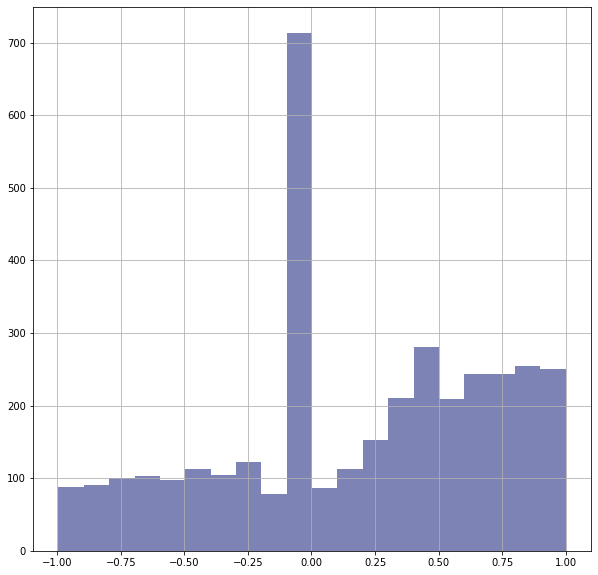

In [47]:
# plot distribution of sentiment scores
import matplotlib as plt

data_clean2['senti'].hist(bins=20, figsize=(10,10), color='#5C64A2',
                            linewidth=0, alpha=0.8)


In [38]:
# compute average senti score per topic
sent_per_topic = data_clean2.groupby('topic').mean()

In [39]:
# get overall sentiment
def get_general_sentiment(senti_score):
    if senti_score >= 0.05 :
        x = "Positive"
    elif senti_score <= - 0.05 :
        x = "Negative"
    else :
        x = "Neutral"
    return x

sent_per_topic['sentiment'] = sent_per_topic['senti'].apply(get_general_sentiment)

NOPE

---

In [ ]:
# topic representation - BIGRAMS
# model.update_topics(list(data_clean2[0]), topics, n_gram_range=(1, 3))

In [ ]:
# get new topic representation
# model.get_topic_freq().head()

In [ ]:
# model.get_topic(0)

Use a custom CountVectorizer instead:

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range=(1, 3), stop_words="english")
model.update_topics(list(data_clean2[0]), topics, vectorizer_model=cv)

In [ ]:
model.get_topic_freq().head()

In [ ]:
model.get_topic(0)

Try using the 'auto' option for number of topics:

In [ ]:
# automatically reduce topics
# model_auto = BERTopic(calculate_probabilities=True, nr_topics='auto')
# topics_auto, probabilities_auto = model_auto.fit_transform(list(data_clean2[0]))

In [ ]:
# model_auto.get_topic_freq().head()

In [ ]:
# model_auto.get_topic(2)

In [ ]:
# visualize topics
# model_auto.visualize_distribution(probabilities_auto[0])
# bad probabilites

---

**model with raw data**

In [ ]:
# need to set environment variable to disable token parallelization
# see issue https://github.com/huggingface/transformers/issues/5486
# TOKENIZERS_PARALLELISM = True

In [ ]:
# according to fitting error, there is a NaN in the data
# sequence item 57: expected str instance, float found

import numpy as np
# data_raw2 = data_raw.dropna()

In [ ]:
# model = BERTopic(nr_topics=30)
# topics, probabilities = model.fit_transform(list(data_raw2[0]))

In [ ]:
# model.get_topic_freq().head()

-1 refers to all outliers which do not have a topic assigned. Forcing documents in a topic could lead to poor performance. Thus, we ignore Topic -1

In [ ]:
# lets look at topic 0

# model.get_topic(0)

In [ ]:
# save model
# model.save('../models/bertopic_model_raw')

a lot of stop words included so will repeat with clean data (ABOVE)